In [1]:
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp
import tqdm as tqdm
import numpy as np
import glob
import joblib

from keypoint_moseq.util import *
from keypoint_moseq.gibbs import *
from keypoint_moseq.initialize import *

### Load data

In [2]:
# make a list of sessions to include
latents_paths = glob.glob('/n/groups/datta/Jonah/Thermistor_only_recordings/*/*/*latents.npy')

# load data to dict, then reshape into array of batches
data_dict = {p.split('.latents.npy')[0]:np.load(p).squeeze() for p in latents_paths}
x,mask,keys = merge_data(data_dict, batch_length=10000)

# convert from numpy arrays to jax device arrays and whiten
x,mask = jnp.array(x),jnp.array(mask)
x, *whitening_params = whiten_all(x,mask)

### Define hyper-params

In [3]:
latent_dim = x.shape[-1] # number of PCs
num_states = 100         # max number of states
nlags = 3                # number of lags for AR dynamics

trans_hypparams = {
    'gamma': 1e3, 
    'alpha': 5.7, 
    'kappa': 1e6,
    'num_states':num_states}

ar_hypparams = {
    'nu_0': latent_dim+2,
    'S_0': 0.01*jnp.eye(latent_dim),
    'M_0': jnp.pad(jnp.eye(latent_dim),((0,0),((nlags-1)*latent_dim,1))),
    'K_0': 10*jnp.eye(latent_dim*nlags+1),
    'num_states':num_states,
    'nlags':nlags}

### Initialize

In [4]:
key = jr.PRNGKey(0)
data = {'mask':mask}
states = {'x':x}
params = {}

params['betas'],params['pi'] = initial_hdp_transitions(key, **trans_hypparams)
params['Ab'],params['Q']= initial_ar_params(key, **ar_hypparams)
states['z'] = resample_stateseqs(key, **data, **states, **params)[0]

### Gibbs sampling
To set `kappa`, run Gibbs sampling with `num_iters=20` and iteratively adjust until the target syllable duration is acheived. Then increase to `num_iters=500` and run to completion. 

 45%|█████████████████████████████▋                                    | 9/20 [00:40<00:42,  3.89s/it]

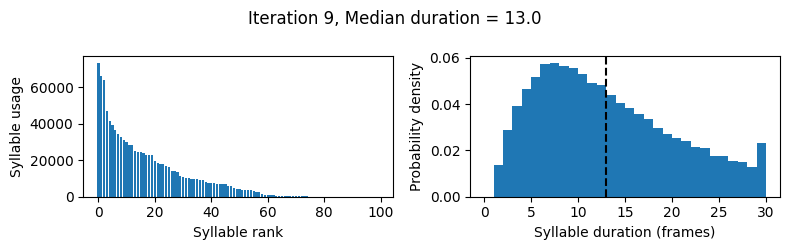

 95%|█████████████████████████████████████████████████████████████▊   | 19/20 [01:20<00:03,  3.79s/it]

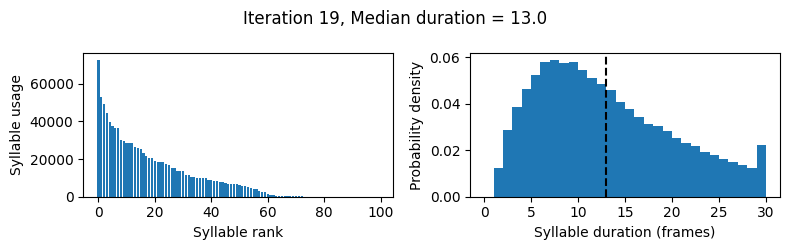

100%|█████████████████████████████████████████████████████████████████| 20/20 [01:24<00:00,  4.23s/it]


In [5]:
num_iters = 20
plot_iters = 10

keys = jr.split(key,num_iters)
stateseq_history = []
for i in tqdm.trange(num_iters):
    
    params['betas'],params['pi'] = resample_hdp_transitions(
        keys[i], **data, **states, **params, **trans_hypparams)
    
    params['Ab'],params['Q']= resample_ar_params(
        keys[i], **data, **states, **params, **ar_hypparams)
    
    states['z'] = resample_stateseqs(
        keys[i], **data, **states, **params)[0]
    
    stateseq_history.append(np.array(states['z'][0]))
    
    if (i+1) % plot_iters == 0:
        usage,durations = stateseq_stats(states['z'], mask)
        fig,axs = plt.subplots(1,2)
        axs[0].bar(range(len(usage)),sorted(usage, reverse=True))
        axs[0].set_ylabel('Syllable usage')
        axs[0].set_xlabel('Syllable rank')
        axs[1].hist(durations, range=(0,30), bins=30, density=True)
        axs[1].axvline(np.median(durations), linestyle='--', c='k')
        axs[1].set_xlabel('Syllable duration (frames)')
        axs[1].set_ylabel('Probability density')
        fig.set_size_inches((8,2.5))
        plt.suptitle('Iteration {}, Median duration = {}'.format(i, np.median(durations)))
        plt.tight_layout()
        plt.show()


### Visualize convergence of state sequence

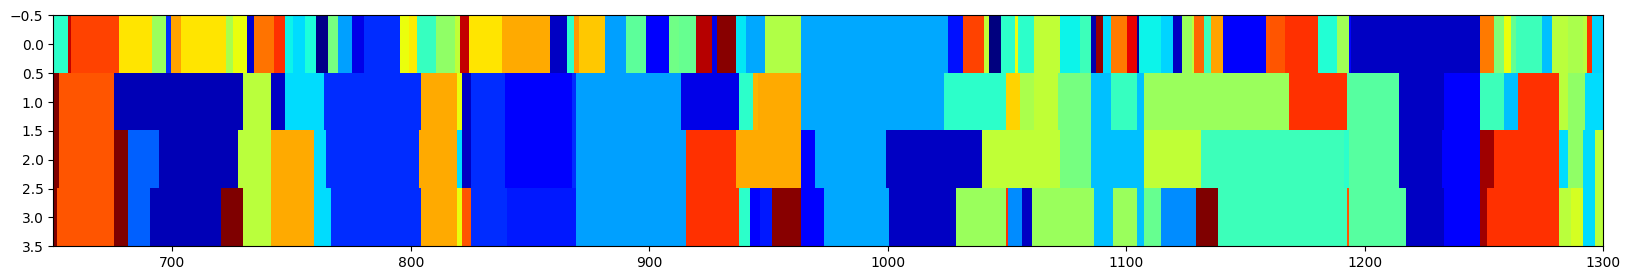

In [13]:
plt.imshow(stateseq_history, aspect='auto', interpolation='nearest', cmap=plt.cm.jet)
plt.xlim([650,1300]) # only the first 10000 frames were saved, so pick any interval in that range
plt.gcf().set_size_inches((20,3))

### Save model
This only saves the parameters, not the state sequence. Use the `apply_model.ipynb` notebook to save state sequences. 

In [14]:
save_path = '/n/groups/datta/caleb/21_2_19_segmentation_redux/tb_jonah/moseq_model_only20_iters.p'

joblib.dump({
    'params' : {k:np.array(v) for k,v in params.items()},
    'ar_hypparams' : {k:np.array(v) for k,v in ar_hypparams.items()},
    'trans_hypparams' : trans_hypparams,
    'whitening_params': [np.array(x) for x in whitening_params],
}, save_path)


NameError: name 'joblib' is not defined